# Section 1: Import of data and general tools

In this section we will import necessary tools and data for our regression and classification tasks.
First, we import data and libraries necessary for the research.

In [33]:
# shutting down warnings
import warnings
warnings.filterwarnings("ignore")

# import of general libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.base import BaseEstimator

# import of sklearn metrics, scalers and models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, StratifiedKFold, ShuffleSplit

# defining random state for repeatability of the code
RANDOM_STATE = 319

#### Data import
The data itself is not part of the git repository. Please, change relative paths to the data on our machine in case those are differ from ones stated below. Original source of data is presented in README.md file.

In [34]:
# defining path for training dataset and data import
PATH_REG_TRAIN = "./bitrate_prediction/bitrate_train.csv"
PATH_REG_TEST = "./bitrate_prediction/bitrate_test.csv"
PATH_CLASS_TRAIN = "./stream_quality_data/train_data.csv"
PATH_CLASS_TEST = "./stream_quality_data/test_data.csv"

x_train_c = pd.read_csv(PATH_CLASS_TRAIN)
x_test_c = pd.read_csv(PATH_CLASS_TEST)
x_train_r = pd.read_csv(PATH_REG_TRAIN)
x_test_r = pd.read_csv(PATH_REG_TEST)

#### Custom functions for later use
In this sub-section we will define few custom functions which will help us with visualisation, model evaluation and other tasks.

First, we define a few functions for visualizing our data:

In [35]:
def plot_confusion_matrix(y_true: np.array, y_pred: np.array)-> np.ndarray:
    """
    Function plots confusion matrix with indication of concrete values.
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: confusion matrix
    """
    fig, ax = plt.subplots()
    cm = confusion_matrix(y_true, y_pred)
    fig.set_size_inches((4,4))
    ax.imshow(cm, cmap="gray")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="red")
    plt.show()

    return cm

def plot_dataset(ds: pd.DataFrame, labels: pd.Series, alpha: float = 0.005)-> None:
    """
    Plots all features from dataset in three columns:
    1st column plots scatter of a pair of Nth and Nth+1 features
    2nd column plots scatter of a pair of Nth feature and label
    3rd column plots scatter of a pair of Nth+1 feature and label
    Additionally, function plots red lines establishing the means of the features
    :param ds: dataset for plotting
    :param labels: a series, which will be plotted against each feature
    :param alpha: density variable
    :return: None
    """

    rows = ds.shape[1]//2+ds.shape[1]%2
    fig, ax = plt.subplots(rows, 3)
    fig.set_size_inches(12,4 * rows)
    for i in range(0, ds.shape[1]-1, 2):
        row = i//2
        ax[row, 0].scatter(ds.iloc[:,i], ds.iloc[:,i+1], alpha=alpha)
        ax[row, 0].axvline(np.mean(ds.iloc[:,i]), c = 'red')
        ax[row, 0].axhline(np.mean(ds.iloc[:,i+1]), c = 'red')
        ax[row, 0].set_title(f'{ds.columns[i]} | {ds.columns[i+1]}')

        ax[row, 1].scatter(ds.iloc[:,i], labels, alpha=alpha)
        ax[row, 1].axvline(np.mean(ds.iloc[:,i]), c = 'red')
        ax[row, 1].set_title(f'{ds.columns[i]} | target')

        ax[row, 2].scatter(ds.iloc[:,i+1], labels, alpha=alpha)
        ax[row, 2].axvline(np.mean(ds.iloc[:,i+1]), c = 'red')
        ax[row, 2].set_title(f'{ds.columns[i+1]} | target')

    if ds.shape[1]//2 == 1:
        ax[ds.shape[1]//2, 1].scatter(ds.iloc[:,-1], labels, alpha=alpha)
        ax[ds.shape[1]//2, 1].set_title(f'{ds.columns[-1]} | target')
    plt.show()

    return None

def plot_boxplots(ds: pd.DataFrame)-> None:
    """
    Plots boxplots of each feature in dataset.
    :param ds: dataset
    :return: None
    """
    rows = ds.shape[1]//3 + int(ds.shape[1]%3!=0)
    fig, ax = plt.subplots(rows, 3)
    fig.set_size_inches(12,rows * 4)

    for i, n in enumerate(ds.columns):
        ax[i//3, i%3].boxplot(ds[n])
        ax[i//3, i%3].set_title(n)

def plot_corr_matrix(ds: pd.DataFrame)-> pd.DataFrame:
    """
    Function plots correlation matrix
    :param ds: dataset
    :return: raw correlation matrix
    """
    cols = ds.columns
    data = np.round(ds.corr(),2)

    fig, ax = plt.subplots()
    fig.set_size_inches((12,12))
    ax.imshow(data, cmap="gray")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(cols.shape[0]), labels=cols)
    ax.set_yticks(np.arange(cols.shape[0]), labels=cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(cols.shape[0]):
        for j in range(cols.shape[0]):
            text = ax.text(j, i, data.iloc[i, j],
                           ha="center", va="center", color="red")

    fig.tight_layout()
    plt.show()

    return data


Then we will define a function which will help us efficiently evaluate our models. The function will accept data which passed feature engineering / scaling and evaluate pre-trained model or train model itself using train data.

In [36]:
def evaluate_model(model: 'ML model',
                   x_train: pd.DataFrame=False, y_train: pd.Series=False,
                   x_test: pd.DataFrame=False, y_test: pd.Series=False,
                   metrics: dict={"r2_score" : r2_score, "mse" : mean_squared_error},
                   fit_model: bool= False)-> list:
    """
    Function accepts model for evaluation and use passed metrics to measure it's performance on test data. If needed, function can train model using train data.
    :param model: an ML model class object with fit() and predict() methods.
    :param x_train: dataset for model training. If test data is absent, model evaluate it's performance on train data.
    :param y_train: train labels. If test data is absent, model evaluate it's performance on train data.
    :param x_test: dataset for model evaluation
    :param y_test: labels for model evaluation
    :param metrics: dictionary of metrics required for evaluation
    :param fit_model: model training flag. If True, model will be fitted on train data
    :return: returns list of scores, trained model and predicted labels
    """
    if type(x_test) == bool or type(y_test) == bool:
        x_test = x_train
        y_test = y_train

    if fit_model:
        model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    scores = {}
    for t in metrics.keys():
        scores.update({t : metrics[t](y_test, y_pred)})

    return scores, model, y_pred


For classification task we will need our Classifier class to operate with classification models more conveniently.

In [37]:
class Classifier(BaseEstimator):
    def __init__(self, subestimator, threshold=0.5):
        self.subestimator=subestimator
        self.threshold=threshold

    def fit(self, x, y):
        self.subestimator.fit(x, y)

    def predict(self, x):
        return self.subestimator.predict_proba(x)[:,0] < self.threshold

    def get_params(self, deep=True):
            return {'threshold':self.threshold,
                    'subestimator': self.subestimator}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Finally, we will define our class of polynomial model. This will allow us efficiently create models with polynomial features.

In [38]:

class Polynomial(BaseEstimator):
    """
    Allows to fit any model using polynomial features
    """
    def __init__(self, degree=2, subestimator=LinearRegression()):
        self.degree = degree
        self.subestimator = subestimator

    def fit(self, X, y):
        self.poly_transform = PolynomialFeatures(self.degree).fit(X)
        self.subestimator.fit(self.poly_transform.transform(X), y)

    def predict(self, X):
        return self.subestimator.predict(self.poly_transform.transform(X))

    def get_params(self, deep=True):
        return {'degree':self.degree,
                'subestimator': self.subestimator}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Section 2: Regression problem
In this section we will look at the problem of predicting bitrate based in cloud gaming session data. During our research we will take a look at data, determine feature engineering process and measure performance of a few models.


#### Section 2.1: Regression data visualization and overview
In this section we will perform general overview of our data and determine general hypothesis regarding feature engineering process.

First, let's look at general statistics of our features displayed below:

I note that maximum values of each feature drastically differs from 75% quantiles which indicated highly imbalanced features and huge amount of noise in data.

Among the features' names we can clearly define our target column called 'target'. However, two more columns are most likely connected with our bitrate prediction goal - "bitrate_std" and "bitrate_mean". Research on dependency of a variable mean or std to the variable itself would not have been useful as we usually do not possess knowledge of a variable's distribution. Thus, we will eliminate those columns later.

As it is shown in output below, all features are numerical and thus feature encoding is not necessary for this case. There are no empty data either thus we do not need to impute empty values.

In [39]:
x_train_r.describe().T

,count,mean,std,min,25%,50%,75%,max
fps_mean,379021.0,35.231127,10.975010,10.0,28.800000,30.000000,43.600000,125.800000
fps_std,379021.0,1.725705,2.505942,0.0,0.316228,0.942809,2.233582,307.167273
rtt_mean,379021.0,49.623858,94.781098,0.0,14.300000,32.200000,55.900000,12898.400000
rtt_std,379021.0,12.763672,112.684460,0.0,0.699206,1.433721,4.948625,40721.933293
dropped_frames_mean,379021.0,0.180451,1.732890,0.0,0.000000,0.000000,0.000000,540.000000
dropped_frames_std,379021.0,0.469548,3.157866,0.0,0.000000,0.000000,0.000000,202.385770
dropped_frames_max,379021.0,1.450719,9.670928,0.0,0.000000,0.000000,0.000000,640.000000
bitrate_mean,379021.0,7516.585502,6073.992189,0.0,2773.300000,6287.200000,10187.200000,64913.500000
bitrate_std,379021.0,1603.487501,1721.021623,0.0,383.683550,1112.710010,2241.848801,26908.532303
target,379021.0,7525.396231,6070.817736,0.0,2785.000000,6296.000000,10192.000000,64913.000000


Let's take a look at the correlation matrix:

As it shown below, bitrate_mean and bitrate_std are highly correlated to each other and to the target thus those are probably derived from each other.

In addition, dropped_frames_max and dropped_frames_std are highly correlated with each other. Thus, deletion of one of those features will not seriously impact the model's outcome.

The rest of the features are barely correlate with the target variable which will make creation of linear model challenging as there is no linear correlation between the features and the target. fps_mean variable promises to be the most useful feature as it has the highes correlation coefficient (0.2) with the target.


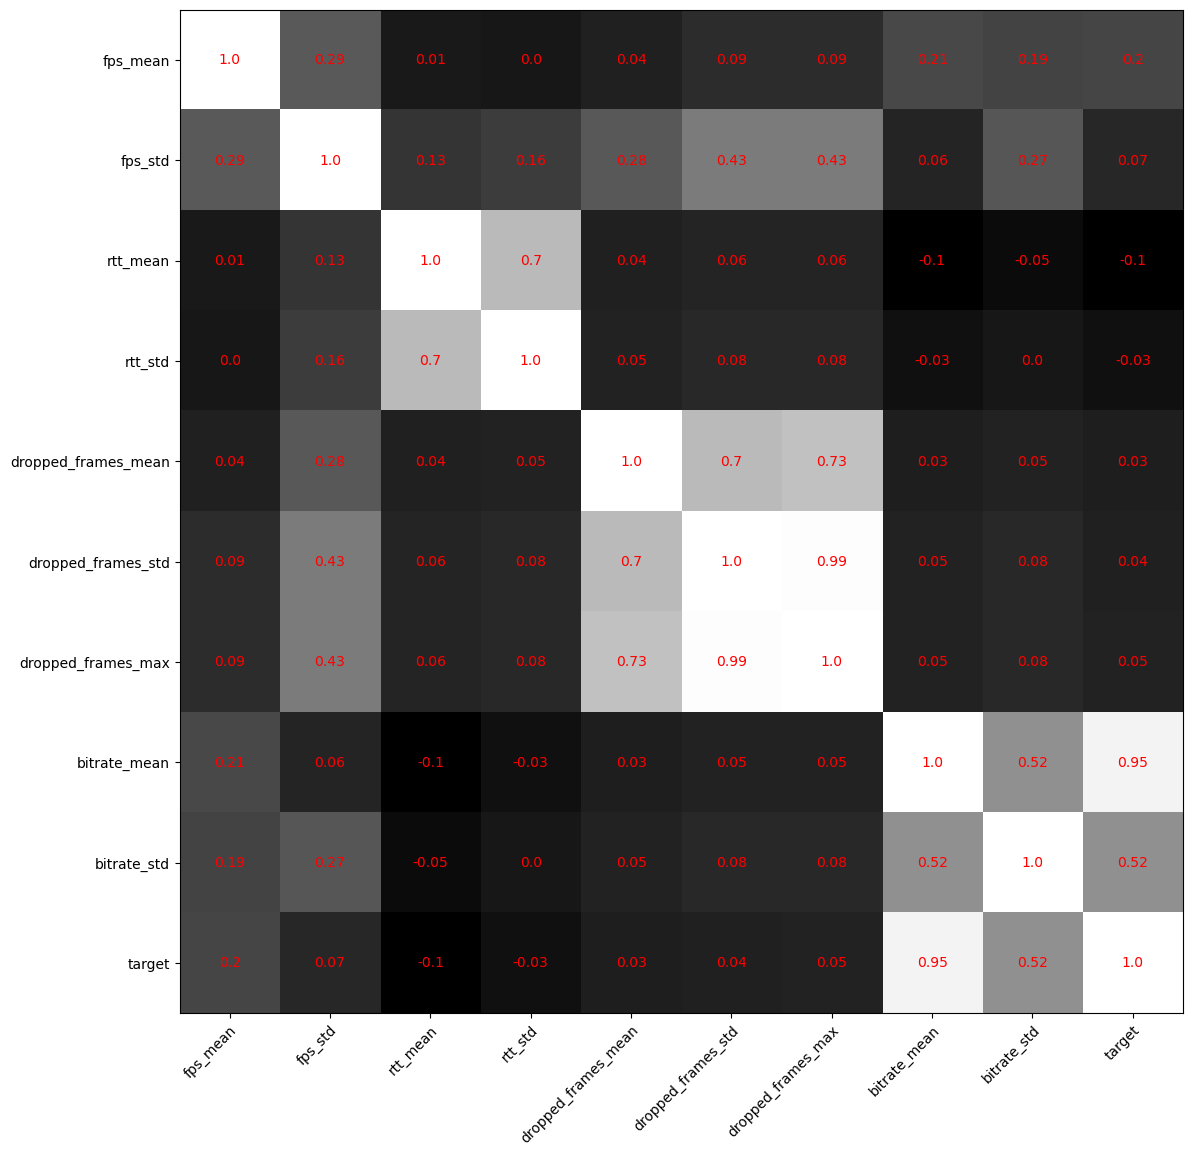

In [40]:
_ = plot_corr_matrix(x_train_r)

Now we will plot boxplots and get a perspective on data distribution.
As it shown below, on a most of the plots boxes are not even visible, indicating that maximum values are strongly higher or lower of the respective quantiles. Variables most of the features have deliberate outliers which we will clear later during the project.

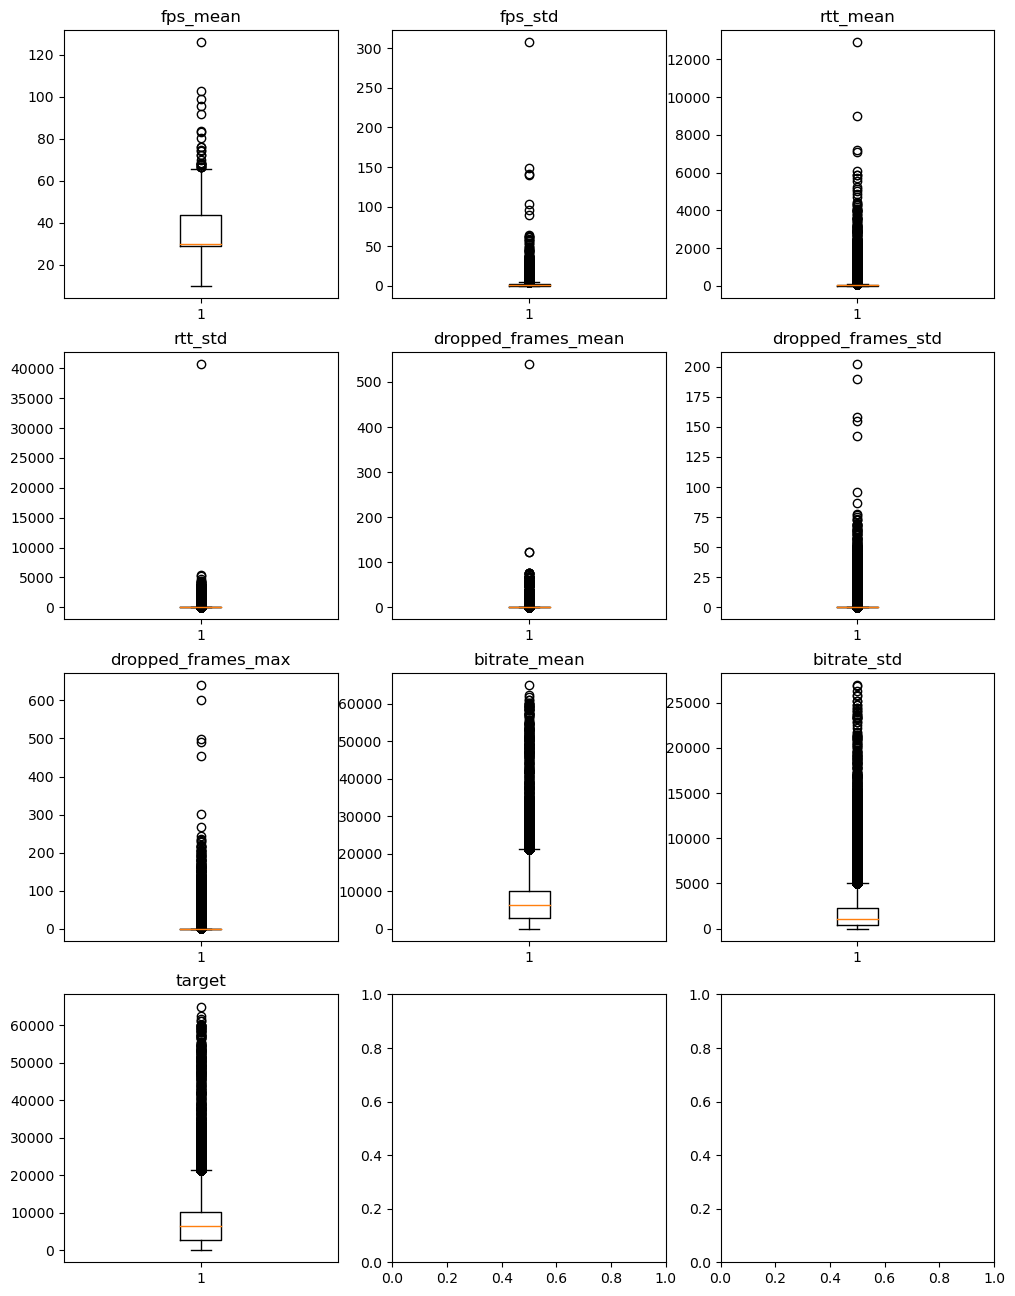

In [41]:
plot_boxplots(x_train_r)

So let's try to "zoom in" on data and try to identify outliers. Based on boxplot above we will filter some outliers and fix a number of discarded observations.

As it shown in output below, after removing 1% of the dataset, we still observing potential outliers in many variables. However, boxplots themselves are at least visible which indicates improvements in the data distribution.

Extracting more observation may impact generalisation of the model which will make it less stable on different dataset. Thus, we will not eliminate any more outliers at the moment.

Initial shape: (379021, 10)
Current shape: (373360, 10)
Overall reduction: 0.01


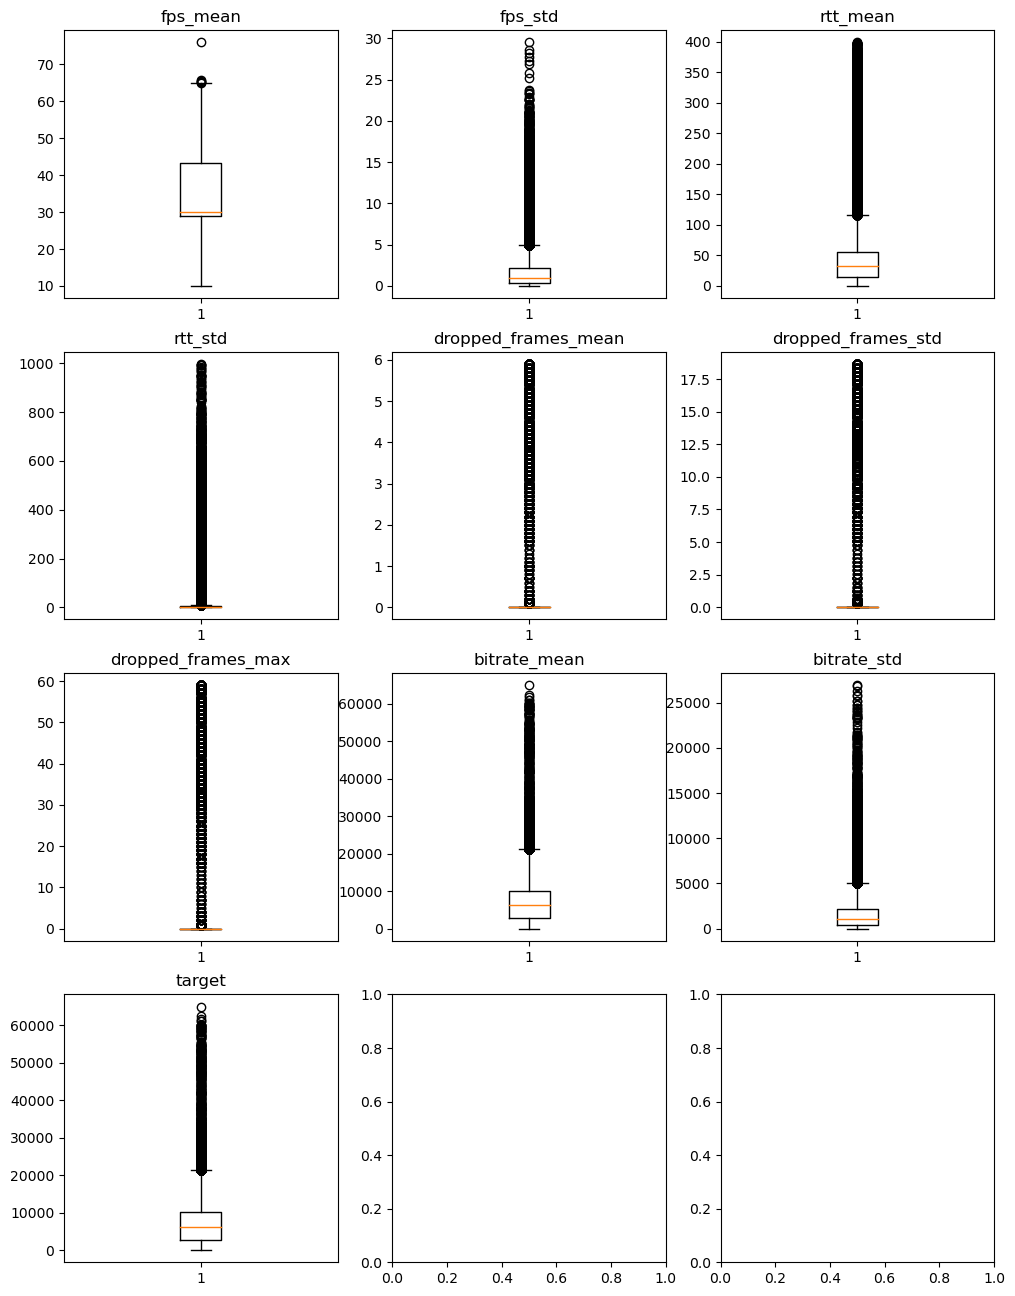

In [42]:
x_train_r_no_outl = x_train_r.copy()
x_train_r_no_outl = x_train_r_no_outl.loc[x_train_r_no_outl["rtt_std"] < 1000]
x_train_r_no_outl = x_train_r_no_outl.loc[x_train_r_no_outl["rtt_mean"] < 400]
x_train_r_no_outl = x_train_r_no_outl.loc[(x_train_r_no_outl["fps_mean"] < 80)]
x_train_r_no_outl = x_train_r_no_outl.loc[(x_train_r_no_outl["dropped_frames_mean"] < 6)]
x_train_r_no_outl = x_train_r_no_outl.loc[(x_train_r_no_outl["dropped_frames_std"] < 100)]
x_train_r_no_outl = x_train_r_no_outl.loc[(x_train_r_no_outl["fps_std"] < 30)]

print(f"Initial shape: {x_train_r.shape}")
print(f"Current shape: {x_train_r_no_outl.shape}")
print(f"Overall reduction: {np.round(1 - x_train_r_no_outl.shape[0] / x_train_r.shape[0], 2)}")

plot_boxplots(x_train_r_no_outl)

Now we will plot out data and will try to identify any potential additional features. Below we can trends of all features against the target and against some plots of features against each other. Red lines indicates mean values of corresponding features.

First of all, we can notice that there is no clear linear dependency between features and the target (excluding bitrate data which we cannot use as was stated above). This conclusion is also supported by correlation analysis conducted above.

If we look at the plot fps_mean | target we can notice that there is a cluster of data which stands out between x values 25-35. This cluster seems independent of the whereas the rest of the dataset does demonstrate a little trend. We can try to assume that 25-35 fps rate is some kind of stable state which is not dependent on the bitrate. Thus, we can try to formulate external binary feature representing that fps_mean is indeed at it's 'stable' state so the model can put negative coefficient to minimize fps_mean contribution in such cases.

Then, we can pay attention to fps_std, rtt_std and rtt_mean features. There we can notice that higher values of the features may correspond with low target value. We can add binary features representing high values to help the model identify potentially low value bitrate.

Then, we can pay attention to fps_std and rtt_std distribution. A lot of observations contain values highly superior to corersponding mean values. We may add logariphmic features to short the distance between average and high values.

Finally, dropped_frames features seems to have either 0 value or values which are not corresponding to the target value. Thus, it is probably safe to exclude them from the analysis. However, it would be logical to add a feature, representing the occurance of dropped frames.

Of course, we can see high correlation between bitrate_mean and target value which is also was seen during correlation analysis.


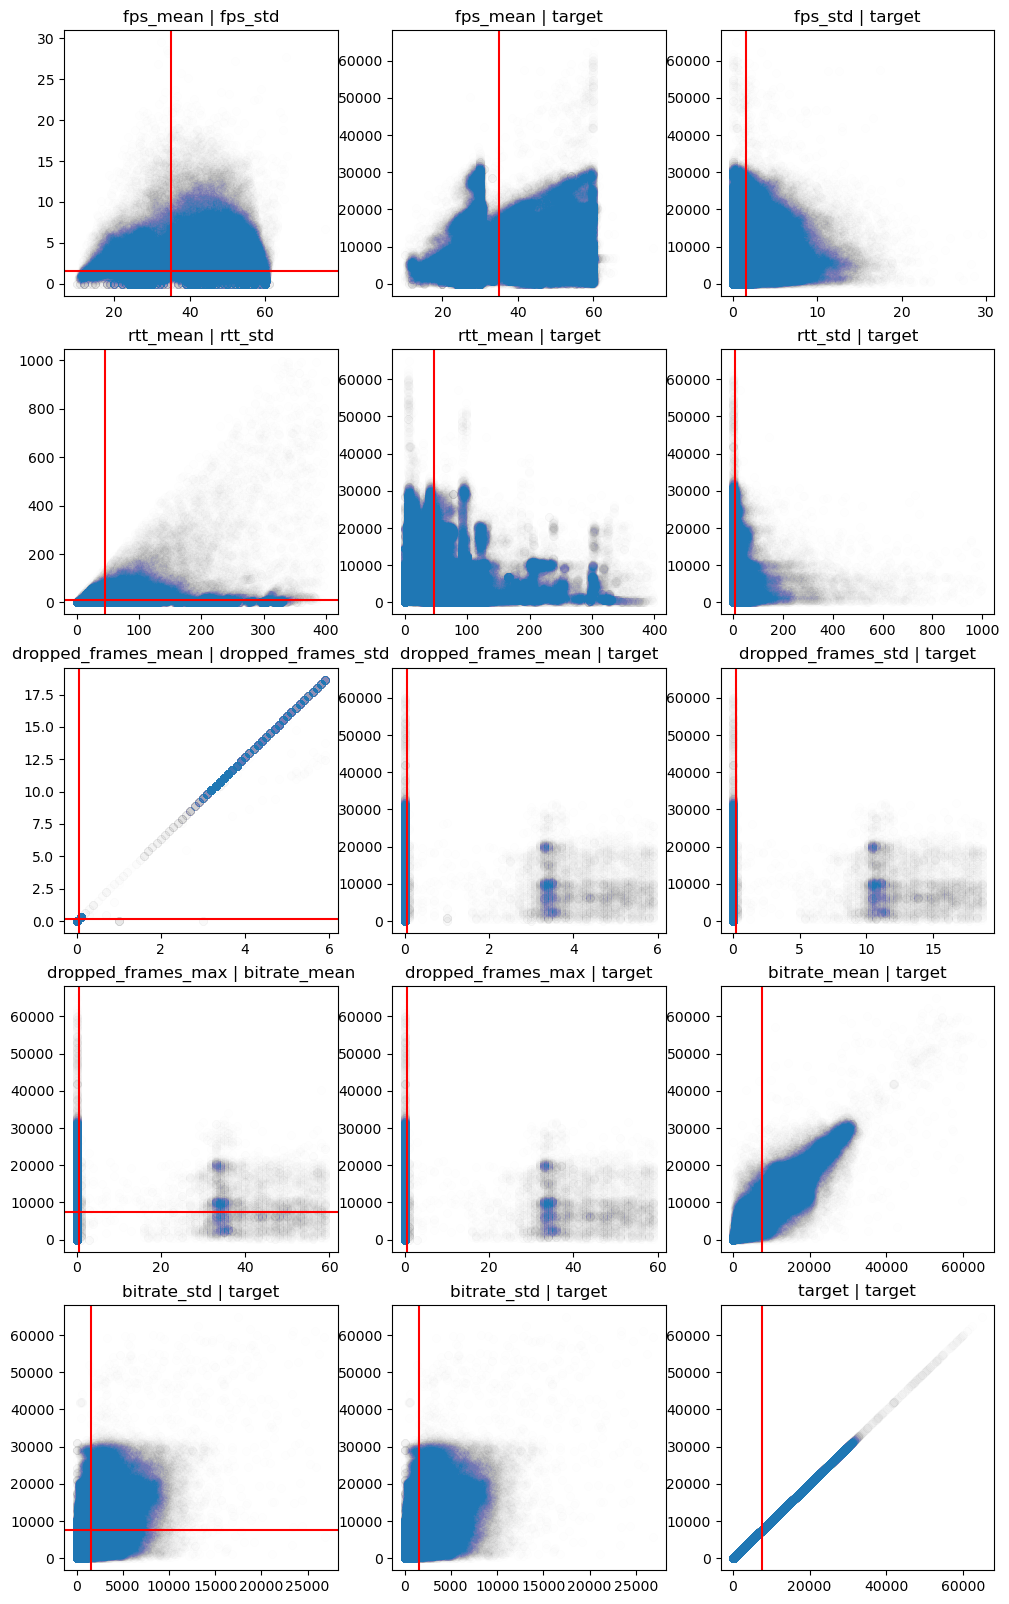

In [43]:
plot_dataset(x_train_r_no_outl, x_train_r_no_outl["target"], alpha=0.005)

Now we will conduct a PCA analysis of the features.

Unfortunately, it does not seem to have a strong effect as PCA 1 does not show any useful dependencies on the target.

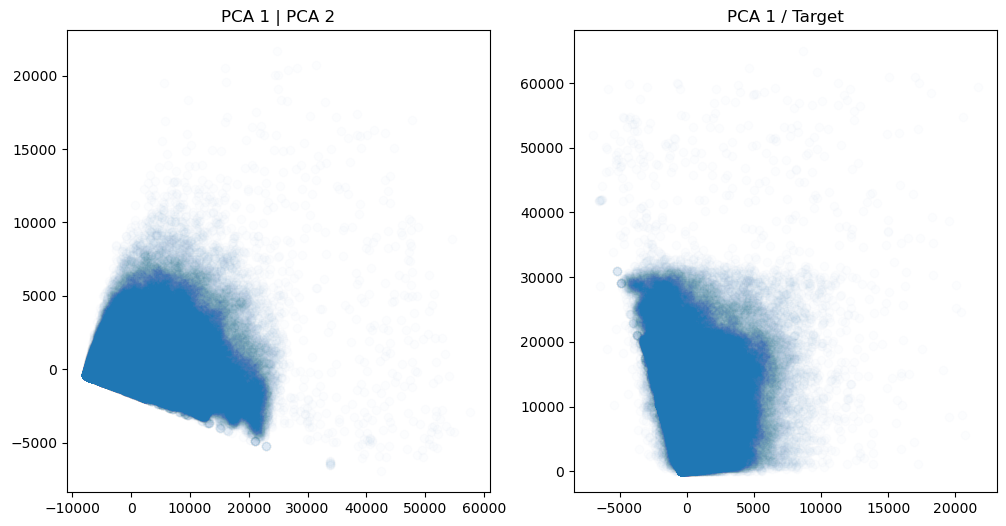

In [44]:
from sklearn.decomposition import PCA

pca = PCA(2).fit(x_train_r_no_outl.drop("target", axis=1), x_train_r_no_outl["target"])
x_train_pca = pca.transform(x_train_r_no_outl.drop("target", axis=1))
#x_train_pca = np.array(list(map(lambda x: min(x[0], 2), x_train_pca)))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

ax[0].scatter(x_train_pca[:,0], x_train_pca[:,1], alpha = 0.01)
ax[0].set_title("PCA 1 | PCA 2")
#ax[0].set_ylim([-4, 4])
#ax[0].set_xlim([-3, 4])
ax[1].scatter(x_train_pca[:,1], x_train_r_no_outl["target"], alpha = 0.01)
ax[1].set_title("PCA 1 / Target")
#ax[1].set_xlim([-3, 10])
plt.show()

#### Section 2.2: Feature engineering

Now we will put everything we learned from visualization into our feature engineering strategy. We will transform our data according to our findings and evaluate usefulness of the features by looking at coefficients of trained linear model.

According to our findings, we will create a function which will transform the data by the following rules:
    1. For training dataset we will exclude outliers found in section 2.1
    2. For any dataset we will add binary features and log features identified in section 2.1
    3. We will scale our data
    4. We will drop duplicated observations

As was expected, we lost appx. 1% of the data during the process.

In [45]:
scaler = None
def reg_pipe(X_: pd.DataFrame, y: pd.Series = False, fit_mode = False, final=True, show_shapes=True)->pd.DataFrame:
    X = X_.copy()

    if show_shapes:
        print(f'Initial data shape: {X.shape}')

    # dropping bitrate features
    X.drop(["bitrate_mean", "bitrate_std"], inplace=True, axis=1)

    # adding binary features
    X['dropped_frames_occured'] = X['dropped_frames_mean'].apply(lambda x: np.int8(x>0))
    X['fps_std'] = X['fps_std'].apply(lambda x: x>6)
    X['fps_unstable'] = X['fps_std'].apply(lambda x: x>5)
    X['rtt_unstable'] = X['rtt_std'].apply(lambda x: x>5)
    X['fps_anomaly'] = X['fps_mean'].apply(lambda x: not (x>25 and x<35))
    X['rtt_anomaly'] = X['rtt_mean'].apply(lambda x: x>50)

    # adding logarithmic features
    X["fps_std_log"] = X["fps_std"].apply(lambda x: np.log(x) if x>2 else x)
    X.drop(["fps_std"], axis=1, inplace=True)
    X['rtt_std_log'] = X['rtt_std'].apply(lambda x: np.log(x) if x>2 else x)
    X.drop(["dropped_frames_mean"], axis=1, inplace=True)

    if fit_mode:
        X["target"] = y

        # dropping duplicates
        X.drop_duplicates(inplace = True)

        # dropping outliers
        X = X.loc[X["rtt_std"] < 1000]
        X = X.loc[(X["fps_mean"] < 80)]
        X = X.loc[X["rtt_mean"] < 600]

    X.drop(["dropped_frames_std", 'dropped_frames_max'], inplace=True, axis=1)
    if final:
        X.drop(["fps_unstable"], inplace=True, axis=1)
        X.drop(["fps_std_log"], inplace=True, axis=1)
    if "target" in X.columns:
        y = X["target"]
        X = X.drop("target", axis=1)

    # scaling the data
    global scaler
    if fit_mode:
        scaler = MinMaxScaler().fit(X)
    X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

    if show_shapes:
        print(f'Out data shape: {X.shape}')

    if type(y) != bool:
        return X, y
    return X


In [46]:
x_train_r_no_target = x_train_r.drop(["target"], axis=1)
x_train_r_piped, y_train_r = reg_pipe(x_train_r_no_target, x_train_r["target"], fit_mode=True, final=False)

Initial data shape: (379021, 9)
Out data shape: (373472, 10)


Now let us train a simple regression model and look at the coefficients to determine contribution of each feature.

It seems that fps_unstable and fps_std_log do not contribute much into the model. We may exclude it from analysis without hurting the model.

In [47]:
model = LinearRegression(fit_intercept=True).fit(x_train_r_piped, y_train_r)
y_train_pred_r = model.predict(x_train_r_piped)

print(f'r2_score: {r2_score(y_train_r, y_train_pred_r)}')
print(f'root mean squared error: {mean_squared_error(y_train_r, y_train_pred_r, squared=False)}')

pd.DataFrame(model.coef_, x_train_r_piped.columns)

r2_score: 0.1050196558270513
root mean squared error: 5741.341937583856


,0
fps_mean,1.124613e+04
rtt_mean,-3.206174e+03
rtt_std,-2.302170e+03
dropped_frames_occured,2.039446e+03
fps_unstable,-4.547474e-13
rtt_unstable,-1.933394e+03
fps_anomaly,-1.822967e+03
rtt_anomaly,-1.932797e+03
fps_std_log,-2.791900e+01
rtt_std_log,2.945939e+03


If we look at the model trained without the feature, we can observe that the scores almost have not changed.
Additionally, we can note that fps_mean seems to be the most important feature for the model.

In [48]:
x_train_r_piped, y_train_r = reg_pipe(x_train_r_no_target, x_train_r["target"], fit_mode=True)

model = LinearRegression(fit_intercept=True).fit(x_train_r_piped, y_train_r)
y_train_pred_r = model.predict(x_train_r_piped)

print(f'r2_score: {r2_score(y_train_r, y_train_pred_r)}')
print(f'root mean squared error: {mean_squared_error(y_train_r, y_train_pred_r, squared=False)}')

pd.DataFrame(model.coef_, x_train_r_piped.columns)

Initial data shape: (379021, 9)
Out data shape: (373472, 8)
r2_score: 0.10501878388273833
root mean squared error: 5741.344734365519


,0
fps_mean,11243.642357
rtt_mean,-3205.897497
rtt_std,-2317.476326
dropped_frames_occured,2024.532774
rtt_unstable,-1933.401144
fps_anomaly,-1824.806335
rtt_anomaly,-1932.620841
rtt_std_log,2946.236396


Now we will revisit our boxplots to check if our feature engineering excersize did affect dataset distribution.

As shown below, our efforts transformed the data into more feasible values with limited amount of potential outliers.

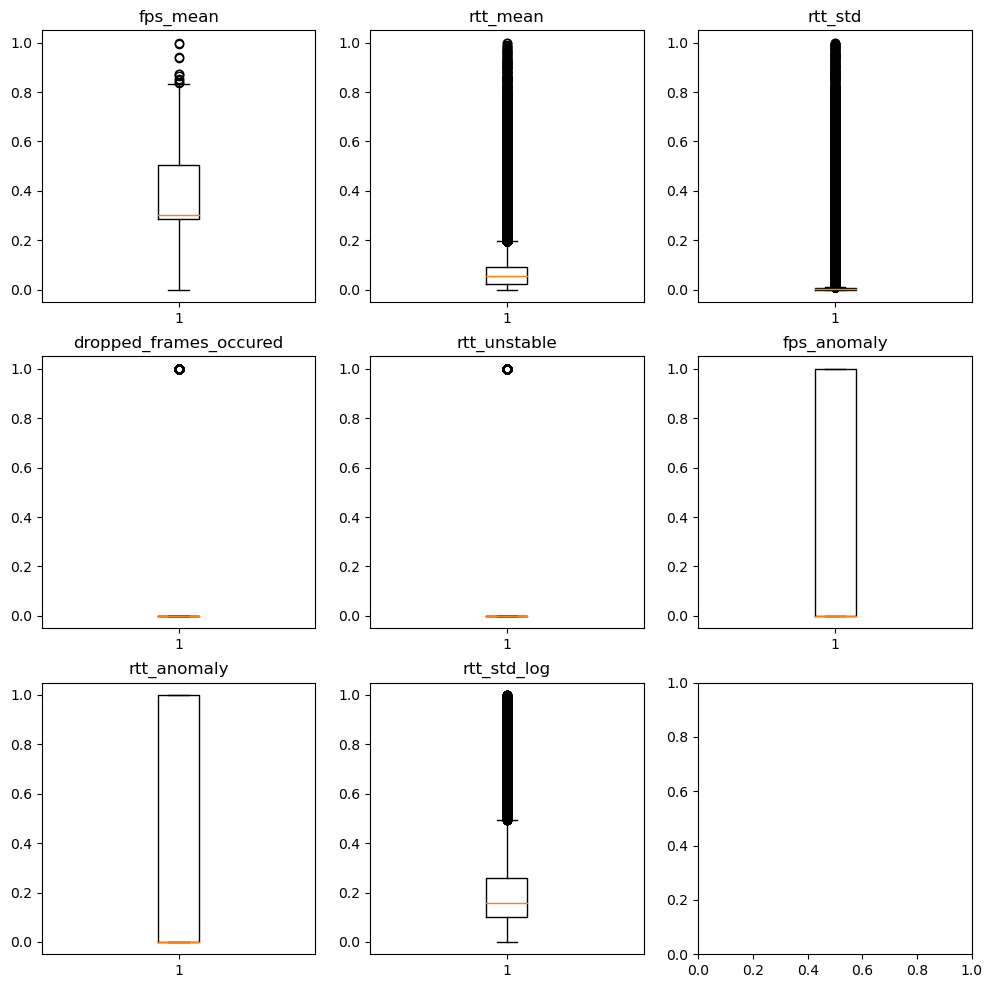

In [49]:
plot_boxplots(x_train_r_piped)

#### Section 2.3: Model selection and validation

In this section we will focus on metric selection and comparison of various models.
We will use 4 kinds of models for our regression task:
    1. Simple Linear Regression model
    2. Simple Linear Regression model with Lasso regularization
    3. Simple Linear Regression model with Ridge regularization
    4. Simple Linear Regression model with Polynomial features
Models 2-4 will require some hyperparametrs to be optimized. Specifically, we have to determine alpha coefficient for Ridge and Lasso and degree for polynomial features.

First, we will experiment with alpha coefficients.
As it shown below, we can make assumption that lower coefficients are shows slightly better results. However, overall performance does not differ from simple linear model.
We can also note slight increase in Root squared error compared to the model trained above which is logical as here we use whole dataset including outliers.

In [50]:
metrics = {
    "r2_score" : r2_score,
    "Root Squared Mean Error" : lambda x, y: mean_squared_error(x, y, squared=False)
}

models = {
    "Simple Linear" : LinearRegression(),
    "Ridge_0.1" : Ridge(0.1),
    "Ridge_0.4" : Ridge(0.4),
    "Ridge_0.7" : Ridge(0.7),
    "Ridge_1.0" : Ridge(1.0),
    "Lasso_0.1" : Lasso(0.1),
    "Lasso_0.4" : Lasso(0.4),
    "Lasso_0.7" : Lasso(0.7),
    "Lasso_1.0" : Lasso(1.0),
}

x_train_r_piped, y_train_r = reg_pipe(x_train_r.drop("target", axis=1), x_train_r["target"], fit_mode=True)
table = []
for n in models:
    scores = evaluate_model(models[n], x_train_r_piped, y_train_r, metrics=metrics, fit_model=True)[0]
    table.append([n] + [scores[t] for t in scores])
print(tabulate(table, headers=["Model"] + [t for t in metrics]))


Initial data shape: (379021, 9)
Out data shape: (373472, 8)
Model            r2_score    Root Squared Mean Error
-------------  ----------  -------------------------
Simple Linear    0.105019                    5741.34
Ridge_0.1        0.105019                    5741.34
Ridge_0.4        0.105019                    5741.34
Ridge_0.7        0.105019                    5741.34
Ridge_1.0        0.105019                    5741.34
Lasso_0.1        0.105018                    5741.35
Lasso_0.4        0.10501                     5741.37
Lasso_0.7        0.10499                     5741.44
Lasso_1.0        0.104961                    5741.53


Now let's experiment with polynomial features and try to understand which degree will be optimal.

As expected, higher polinomial degree improves quality of the predictions on the training dataset. However, we must be careful not to overfit our model with high polynomial features.

In [51]:
metrics = {
    "r2_score" : r2_score,
    "Root Squared Mean Error" : lambda x, y: mean_squared_error(x, y, squared=False),
    "Mean Absolute Error": mean_absolute_error
}

models = {
    "Poly_1" : Polynomial(1),
    "Poly_2" : Polynomial(2),
    "Poly_3" : Polynomial(3),
    "Poly_4" : Polynomial(4),
    "Poly_5" : Polynomial(5)
}

x_train_r_piped, y_train_r = reg_pipe(x_train_r.drop("target", axis=1), x_train_r["target"], fit_mode=True)
table = []
for n in models:
    scores = evaluate_model(models[n], x_train_r_piped, y_train_r, metrics=metrics, fit_model=True)[0]
    table.append([n] + [scores[t] for t in scores])
print(tabulate(table, headers=["Model"] + [t for t in metrics]))


Initial data shape: (379021, 9)
Out data shape: (373472, 8)
Model      r2_score    Root Squared Mean Error    Mean Absolute Error
-------  ----------  -------------------------  ---------------------
Poly_1     0.105019                    5741.34                4443.31
Poly_2     0.128252                    5666.33                4363.23
Poly_3     0.143365                    5617                   4303.13
Poly_4     0.156927                    5572.36                4253.45
Poly_5     0.16723                     5538.21                4227.31


Now we will train our models and evaluate their performance using K-fold analysis. We will break the training set into 4 groups and will train our models 4 times using 3/4 of our data as training set and 1/4 as a validation set. This excersize will demonstrate stability of our models and show flags of overfitting.

As it shown on the plot below, more complicated model tends to perform worse on validation data compared to the train data. Model "Poly_4" seems to be a good compromise between stability and productivity compared to the other models.

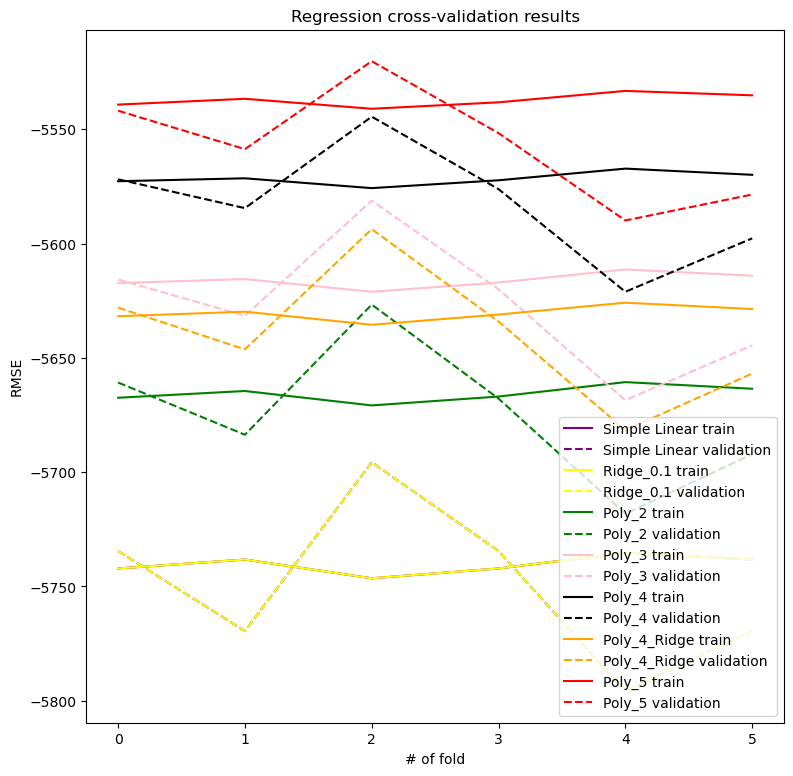

Model          train scores                                                  validation scores
-------------  ------------------------------------------------------------  ------------------------------------------------------------
Simple Linear  [-5742.11198202 -5738.21604481 -5746.41394408 -5742.11208761  [-5734.50249613 -5769.5247888  -5695.64503959 -5734.48162659
                -5735.26545825 -5738.22206557]                                -5795.82369849 -5769.43918496]
Ridge_0.1      [-5742.11198219 -5738.21604498 -5746.41394425 -5742.11208778  [-5734.50248955 -5769.52482184 -5695.64469848 -5734.48148495
                -5735.26545842 -5738.22206573]                                -5795.82367084 -5769.43940505]
Poly_2         [-5667.42226434 -5664.47177606 -5670.7804532  -5666.90075418  [-5660.77247001 -5683.61294459 -5626.66249846 -5667.81096892
                -5660.58754098 -5663.48516299]                                -5718.15796565 -5692.13256973]
Poly_3         [-5617.2575

In [52]:

models = {
    "Simple Linear" : LinearRegression(),
    "Ridge_0.1" : Ridge(0.1),
    "Poly_2" : Polynomial(2),
    "Poly_3" : Polynomial(3),
    "Poly_4" : Polynomial(4),
    "Poly_4_Ridge" : Polynomial(4, Ridge()),
    "Poly_5" : Polynomial(5)
}

x_train_r_piped, y_train_r = reg_pipe(x_train_r.drop("target", axis=1), x_train_r["target"], fit_mode=True, show_shapes=False)

folds=6
table = []
colors = {"red", "yellow","black", "green", "gray", "orange", "purple", "pink"}

plt.rcParams["figure.figsize"] = (9,9)
for n in models:
    c = colors.pop()
    cv = cross_validate(models[n], x_train_r_piped, y_train_r,
                        cv=ShuffleSplit(folds, random_state=RANDOM_STATE),
                        return_train_score=True, scoring='neg_root_mean_squared_error')
    table.append([n, cv["train_score"], cv["test_score"]])
    plt.plot(np.arange(folds), cv["train_score"], c=c, label=f'{n} train')
    plt.plot(np.arange(folds), cv["test_score"], c=c, linestyle="dashed", label=f'{n} validation')

plt.legend(loc='lower right')
plt.title("Regression cross-validation results")
plt.xlabel("# of fold")
plt.ylabel("RMSE")
plt.show()

print(tabulate(table, headers=["Model", "train scores", "validation scores"]))

#### Section 2.4: evaluation of the models
Previously we performed validation of our models on training set and selected optimal parameters. Now we will compare productivity of our best data on test dataset and determine the optimal model for our final solution.
Based on our findings above, I include the following models for evaluation:
    1. Simple linear regression as it is the most stable model.
    2. Polynomial linear regression with 3rd degree as it is great compromise between stability and productivity
    3. Polynomial linear regression with 3rd degree and Lasso regularization as it might preserve strong side of the 2nd model and help with stability of the model.
    4. Polynomial linear regression with 4rd degree as it might be good example of overfitted model

As it shown in the table below, it seems that 3rd model performs better than the others. RMSE is similar to the one observed on the training sets which indicates that there is no overfitting of the model. On the opposite, model "Poly_5" is slightly overfitting as prediction error exceeds one observed earlier on the train data. Still, considering that target mean is less than 8000, I would consider productivety of this model as quite low and abstract.


In [53]:
metrics = {
    "r2_score" : r2_score,
    "Root Squared Mean Error" : lambda x, y: mean_squared_error(x, y, squared=False),
    "Mean Absolute Error": mean_absolute_error
}

models = {
    "Simple Linear" : LinearRegression(),
    "Poly_4" : Polynomial(4),
    "Poly_4_Ridge" : Polynomial(4, Ridge(0.5)),
    "Poly_5" : Polynomial(5),
}

x_train_r_piped, y_train_r = reg_pipe(x_train_r.drop("target", axis=1), x_train_r["target"], show_shapes=False)
x_test_r_piped, y_test_r = reg_pipe(x_test_r.drop("target", axis=1), x_test_r["target"], show_shapes=False)

table = []
for n in models:
    scores = evaluate_model(models[n],x_train_r_piped, y_train_r, x_test_r_piped, y_test_r, metrics=metrics, fit_model=True)[0]
    table.append([n] + [scores[t] for t in scores])
print(tabulate(table, headers=["Model"] + [t for t in metrics]))


Model            r2_score    Root Squared Mean Error    Mean Absolute Error
-------------  ----------  -------------------------  ---------------------
Simple Linear   0.0996303                    5666.37                4317.62
Poly_4          0.119141                     5604.64                4204.54
Poly_4_Ridge    0.120224                     5601.2                 4238.47
Poly_5         -0.20066                      6543.42                4214.65


# Section 3: Classification problem
In this section we will look at the problem of predicting stream quality in cloud gaming session data. During our research we will take a look at data, determine feature engineering process and measure performance of a few models.

#### Section 3.1: Classification data visualization and overview
In this section we will perform general overview of our data and determine general hypothesis regarding feature engineering process. As it shown below, it seems that many features are the same as from regression task. The only features added are few categorical features. For detailed visualization of features 1-8, please, see Section 2.1 where I analysed the features in great detail.

In [54]:
x_train_c.head()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


As for categorical features "auto_bitrate_state" and "auto_fec_state", we can observe that the features can be presented as binary features: auto_fec_state has only two types of entry and auto_bitrate_state has "off" and "full" entries with a few "partial" which can be replaced with "full" entries.

Also note, that target value is highly imbalanced - less than 10% marked as positive. We will deal with that issue later.

In [55]:
print(x_train_c.iloc[:,[8,9,11]].value_counts())
x_train_c_embbedded = x_train_c.copy()
x_train_c_embbedded["auto_bitrate_state"] = x_train_c_embbedded["auto_bitrate_state"].apply(lambda x: x!="off")
x_train_c_embbedded["auto_fec_state"] = x_train_c_embbedded["auto_fec_state"].apply(lambda x: x!="off")

auto_bitrate_state  auto_fec_state  stream_quality
off                 partial         0                 274436
full                partial         0                  62036
off                 off             0                  33795
                    partial         1                  17229
full                off             0                   8141
                    partial         1                   5221
off                 off             1                   4738
full                off             1                    566
partial             partial         0                    300
                                    1                     74
                    off             0                     30
                                    1                      6
dtype: int64


Let us take a look into correlation matrix of classification dataset.
As shown below, we once again can observe dependency between features responsible for dropped frames description. Thus, we will eliminate one of such features.

Othervise, it seems that fps_lags have correlation with our target variable thus we would expect it to play important role in our model.

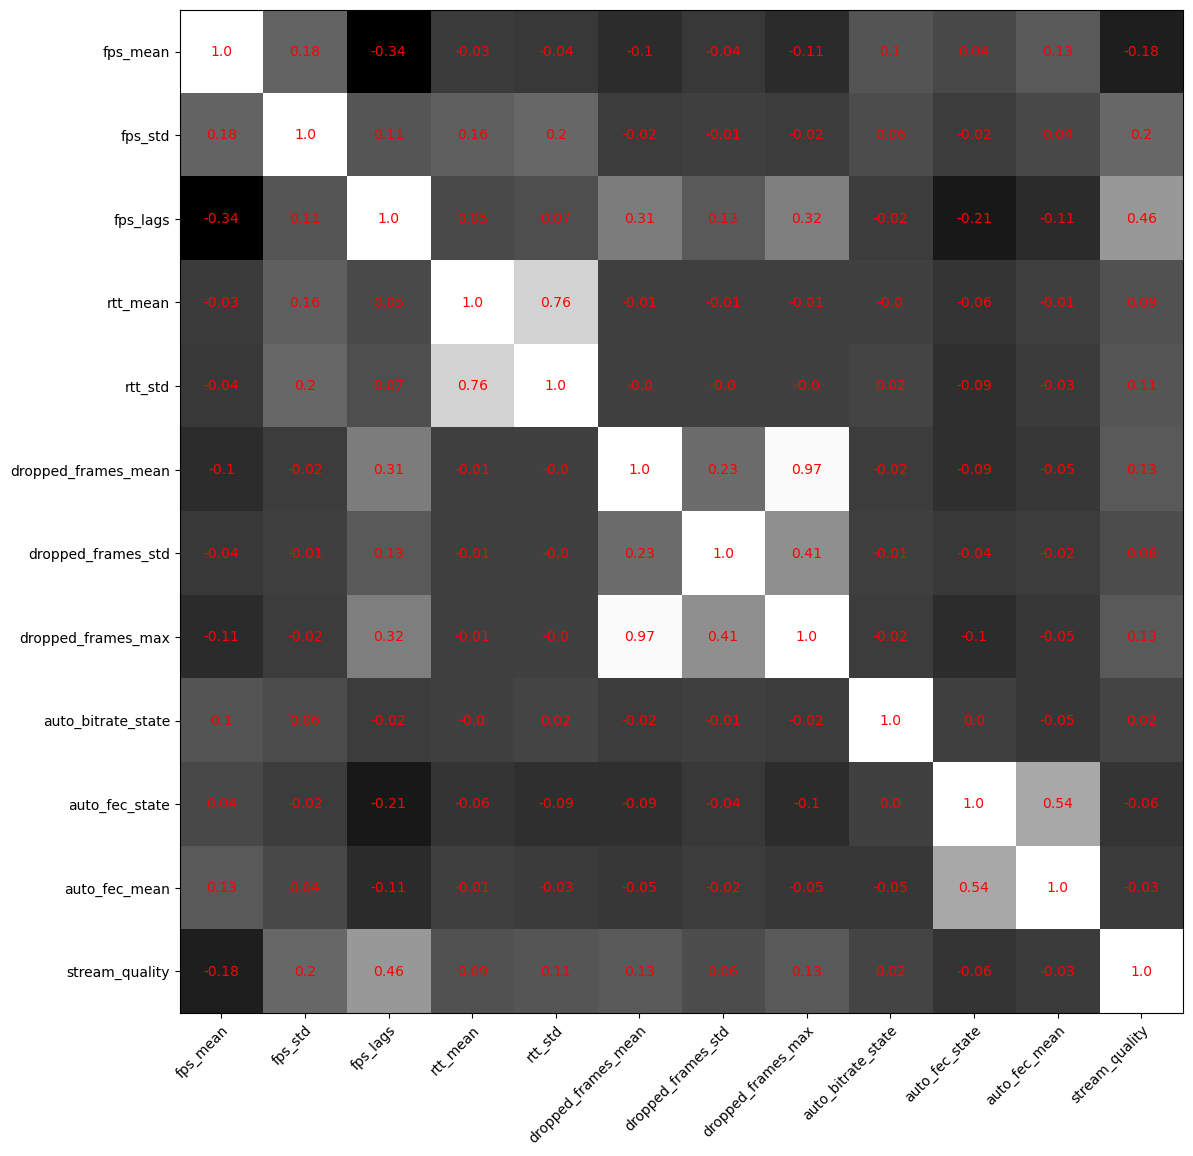

In [56]:
_ = plot_corr_matrix(x_train_c_embbedded)

Let's visualize our data with outlier clean-up as we did in the regression dataset.

It seems, that high fps_lags has some correlation with our target. We might add a feature representing fps_lags > 2.

For non-zero values of dropped_frames features seem to correspond with stream quality. We can add binary feature on occurrence of the dropout during observed session.

It seems that high auto_fec_mean values also corresponds with our target value. We can add a binary feature representing high value of the feature.

Later we will also add few features which were already described in Section 2.1.

(406572, 12)
(394674, 12)


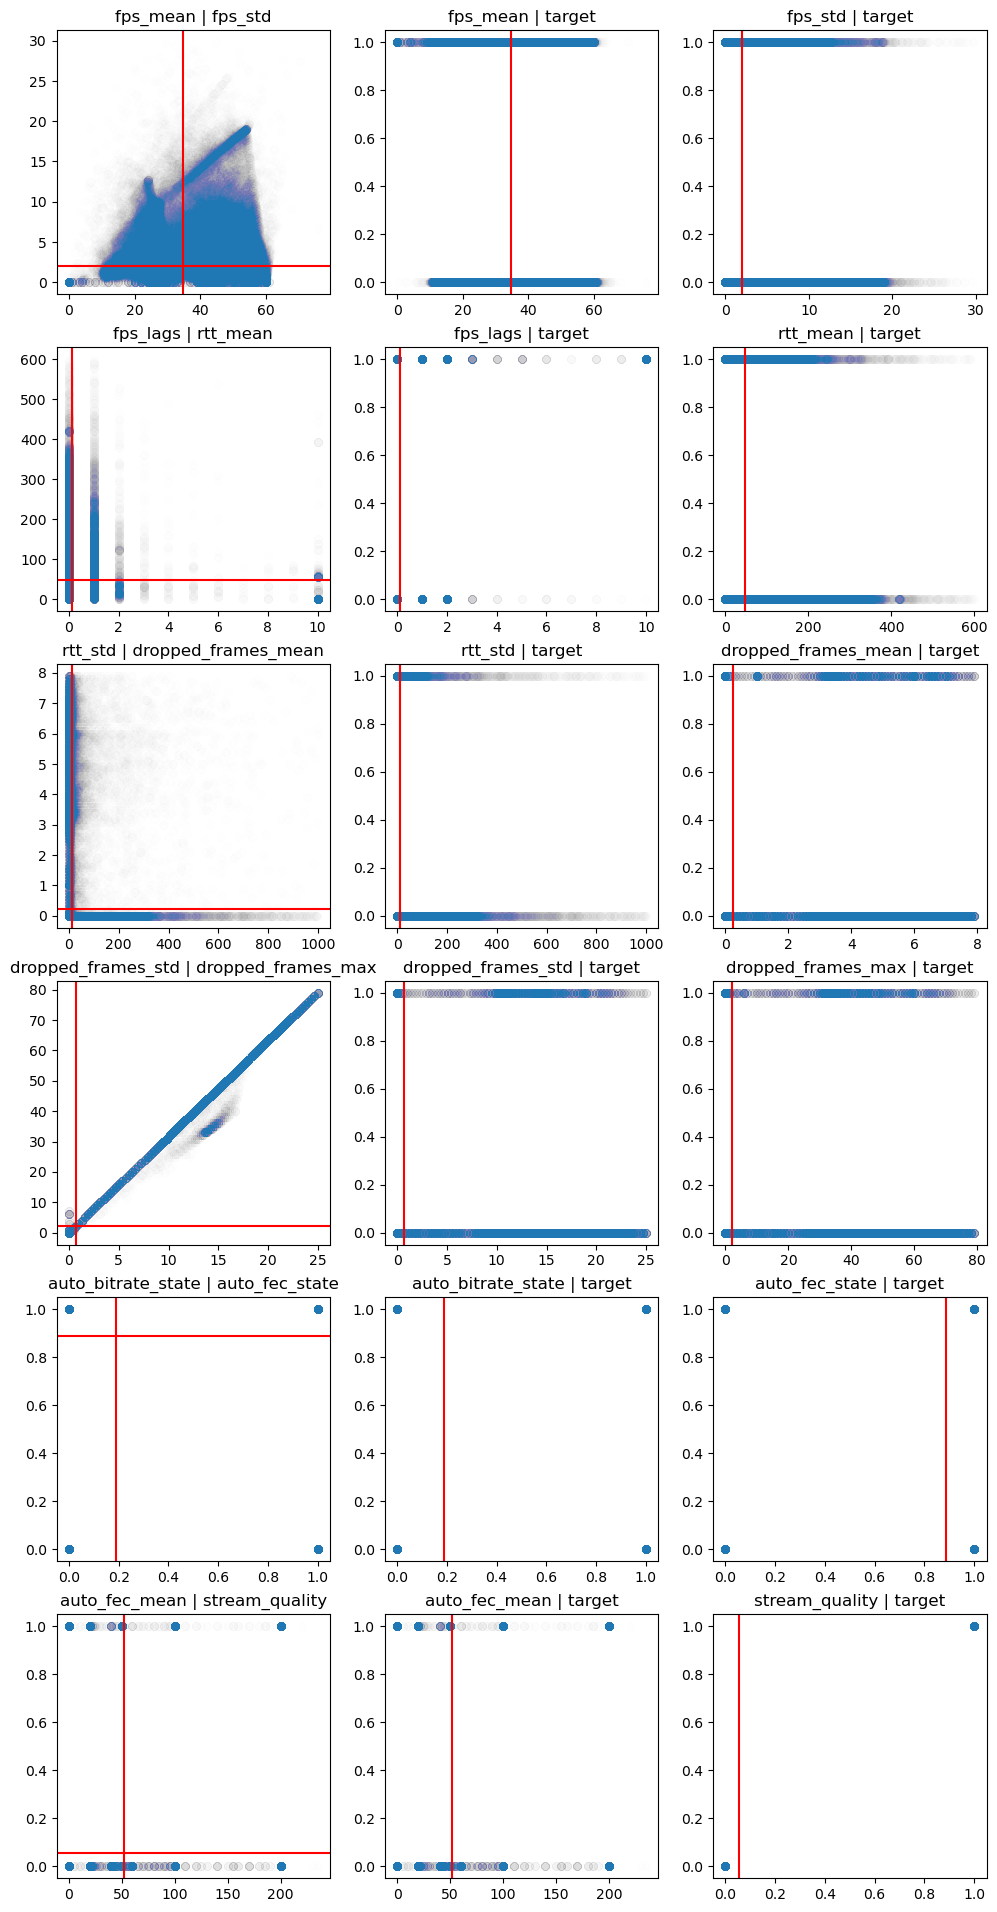

In [57]:
print(x_train_c_embbedded.shape)
x_train_c_cleared = x_train_c_embbedded.copy()
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["fps_std"] < 30]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["fps_mean"] < 80]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["rtt_mean"] < 600]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["dropped_frames_mean"] < 8]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["rtt_std"] < 1000]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["dropped_frames_std"] < 100]
x_train_c_cleared = x_train_c_cleared.loc[x_train_c_cleared["dropped_frames_max"] < 100]

print(x_train_c_cleared.shape)
plot_dataset(x_train_c_cleared, x_train_c_cleared["stream_quality"])

#### Section 3.2: Feature engineering

Now we will put everything we learned from visualization into our feature engineering strategy. We will transform our data according to our findings and evaluate usefulness of the features by looking at coefficients of trained linear model.

According to our findings, we will create a function which will transform the data by the following rules:
    1. For training dataset we will exclude outliers found in section 3.1
    2. For any dataset we will add binary features identified in section 3.1
    3. We will scale our data
    4. We will drop duplicated observations

As was expected, we lost appx. 1% of the data during the process.

In [58]:
scaler_c = None
pca_c = None
def class_pipe(X_: pd.DataFrame, y: pd.Series=False, fit_mode: bool=False, final:bool=True, show_shapes=False, with_pca = False):
    X = X_.copy()

    if show_shapes:
        print(f"Input shape: {X.shape}")

    # dropping features highly correlated with other features
    X.drop(["dropped_frames_max"], inplace=True, axis=1)

    # encoding categorical features
    X["auto_bitrate_state"] = X["auto_bitrate_state"].apply(lambda x: x!="off")
    X["auto_fec_state"] = X["auto_fec_state"].apply(lambda x: x!="off")

    # adding binary features
    X['dropped_frames_occured'] = X['dropped_frames_mean'].apply(lambda x: np.int8(x>0))
    X['fps_unstable'] = X['fps_std'].apply(lambda x: x>5)
    X['rtt_unstable'] = X['rtt_std'].apply(lambda x: x>5)
    X['fps_anomaly'] = X['fps_mean'].apply(lambda x: not (x>20 and x<30))
    X['rtt_anomaly'] = X['rtt_mean'].apply(lambda x: x>50)
    X['fps_lag_huge'] = X['fps_lags'].apply(lambda x: x>2)
    X['auto_fec_mean_high'] = X['auto_fec_mean'].apply(lambda x: x > 50)

    if fit_mode:
        X["stream_quality"] = y
        X.drop_duplicates(inplace = True)

        X = X.loc[X["fps_std"] < 30]
        X = X.loc[X["fps_mean"] < 80]
        X = X.loc[X["rtt_mean"] < 600]
        X = X.loc[X["rtt_std"] < 1000]
        X = X.loc[X["dropped_frames_std"] < 100]

    if final:
        X.drop(["dropped_frames_mean"], axis=1, inplace=True)
        X.drop(["rtt_unstable"], axis=1, inplace=True)

    global pca_c
    features_pca = ["fps_unstable", "fps_anomaly", "rtt_anomaly", "fps_lag_huge", "auto_fec_mean_high",
                    "dropped_frames_std", "auto_bitrate_state", "auto_fec_state", "auto_fec_mean"]

    if with_pca and fit_mode:
        pca_c = PCA(1).fit(X[features_pca])

    if with_pca:
        X["Other_feats"]=pca_c.transform(X[features_pca])
        X.drop(features_pca, axis=1, inplace=True)

    if "stream_quality" in X.columns:
        y = X["stream_quality"]
        X.drop("stream_quality", axis=1, inplace=True)


    global scaler_c
    if fit_mode:

        scaler_c = MinMaxScaler().fit(X)

    X = pd.DataFrame(scaler_c.transform(X), columns=X.columns, index=X.index)

    if show_shapes:
        print(f"Output shape: {X.shape}")

    if type(y) != bool:
        return X, y
    return X



In [59]:
x_train_c_piped, y_train_c = class_pipe(x_train_c.drop("stream_quality", axis=1),x_train_c["stream_quality"], fit_mode=True, show_shapes=True)

Input shape: (406572, 11)
Output shape: (371028, 15)


Now let us train a logistic regression model and look at the coefficients to determine contribution of each feature.

It seems like many of our features do not contribute too much into our model. On the other hand, deliting all of them seems to hurtful for the model the features are not useless according to the coefficients. We can perform dimention reduction with PCA to unite those features into one. Thus, we will save most of the information and significantly reduce the dimentions of our dataset.

In [60]:
model=LogisticRegression().fit(x_train_c_piped, y_train_c)
pd.DataFrame(model.coef_, columns=x_train_c_piped.columns).T

,0
fps_mean,-2.499149
fps_std,1.628067
fps_lags,5.498069
rtt_mean,0.439947
rtt_std,1.141372
dropped_frames_std,0.518376
auto_bitrate_state,0.235656
auto_fec_state,0.594924
auto_fec_mean,-0.359755
dropped_frames_occured,1.027400


As we can see in the table below, our PCA feature does contribute something to our model and only the most useful features stay untouched.

In [61]:
x_train_c_piped, y_train_c = class_pipe(x_train_c.drop("stream_quality", axis=1),x_train_c["stream_quality"], fit_mode=True, with_pca=True)
model=LogisticRegression().fit(x_train_c_piped, y_train_c)
pd.DataFrame(model.coef_, columns=x_train_c_piped.columns).T

,0
fps_mean,-1.689172
fps_std,1.877139
fps_lags,5.795160
rtt_mean,1.141644
rtt_std,0.723113
dropped_frames_occured,1.089065
Other_feats,0.485232


#### Section 3.3: Model selection and validation
Now let us focus on model selection.

As we mentioned before, the dataset is highly imbalanced meaning that more than 90% of the dataset labeled with a single target class. This might seriously affect model quality. We have two options to counter this:
    1. We may train our model on smaller dataset in which label count is approximately the same for each class.
    2. During the model training, we may apply some weights to our smaller class so observations with that class would contribute more.

As the first option would deplete our dataset ten-fold, we will focus on the second option. Accordingly, we will apply weighted coefficients to our metrics: precision score, recall score and f1 score. Accuracy score calculates overall hit of our predicted and real labels so weighted score cannot be applied to such metric. As we can see below, precision score can be hardly gained as TP number will be much lower than FP in the most cases.

accuracy score: 0.8840141444850523
precision score: 0.9194280000785652
recall score: 0.8840141444850523
f1_score score: 0.8991843629006989
precision score unweighted: 0.2578346892600972


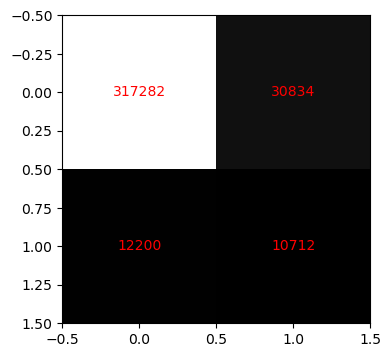

In [62]:
x = x_train_c_piped
y = y_train_c

threshold = 0.5

model = LogisticRegression(max_iter=1000, class_weight="balanced").fit(x_train_c_piped, y_train_c)
y_pred = model.predict_proba(x)[:,0] < threshold

print(f'accuracy score: {accuracy_score(y_train_c, y_pred)}')
print(f'precision score: {precision_score(y_train_c, y_pred, average="weighted")}')
print(f'recall score: {recall_score(y_train_c, y_pred, average="weighted")}')
print(f'f1_score score: {f1_score(y_train_c, y_pred, average="weighted")}')
print(f'precision score unweighted: {precision_score(y_train_c, y_pred)}')

_ = plot_confusion_matrix(y, y_pred)

Now let us define overall optimal threshold for our problem. It is difficult to say, what is more important to us - detect all bad sessions, never mark a bad session as good one or just to make as little mistakes as possible. So, we will try to maximize overall f1 score which should give weighted compromise between precision and recall considering we equally favour the metrics.

To achieve that, we will plot outcome of our model with different threshold and select appropriate value.
As plotted below, it seems that optimal threshold value is 0.11 region. However, we must keep in mind that different models might have different optimum threshold.

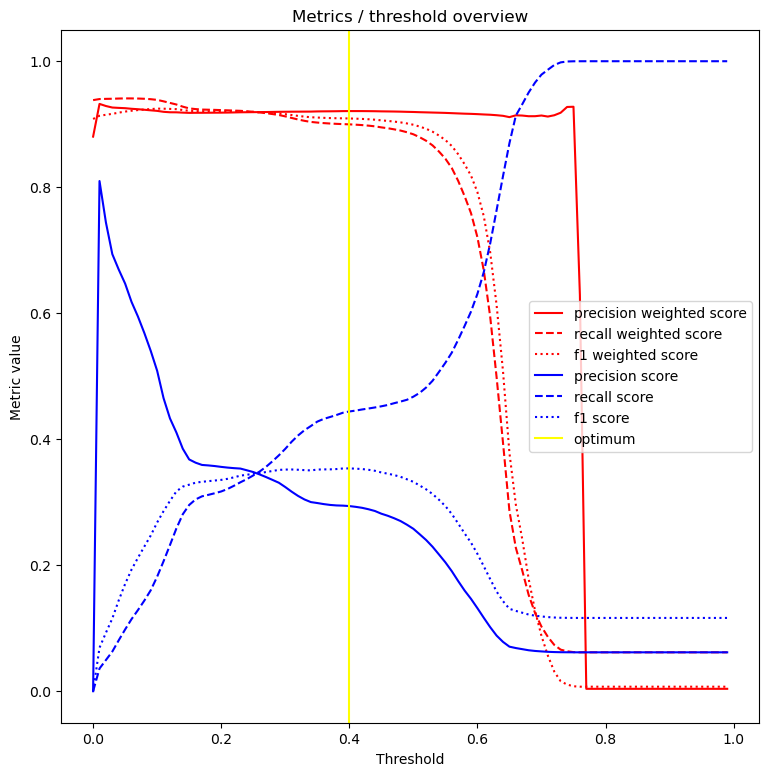

In [63]:
y_proba = model.predict_proba(x_train_c_piped)[:,0]
thr = np.arange(0.0, 1.0, 0.01)

precision_w = [precision_score(y_train_c, y_proba < i, average="weighted") for i in thr]
recall_w = [recall_score(y_train_c, y_proba < i, average="weighted") for i in thr]
f1_w = [f1_score(y_train_c, y_proba < i, average="weighted") for i in thr]
precision = [precision_score(y_train_c, y_proba < i) for i in thr]
recall = [recall_score(y_train_c, y_proba < i) for i in thr]
f1 = [f1_score(y_train_c, y_proba < i) for i in thr]

optimum = thr[np.argmax(f1)]

c="red"
plt.plot(thr, precision_w, c=c, label="precision weighted score")
plt.plot(thr, recall_w, c=c, label="recall weighted score", linestyle="dashed")
plt.plot(thr, f1_w, c=c, label="f1 weighted score", linestyle=":")

c="blue"
plt.plot(thr, precision, c=c, label="precision score")
plt.plot(thr, recall, c=c, label="recall score", linestyle="dashed")
plt.plot(thr, f1, c=c, label="f1 score", linestyle=":")

plt.axvline(optimum, c='yellow', label='optimum')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Metrics / threshold overview")
plt.show()

Now we will train a few models and evaluate their stability using cross-validation technique.
We will train and validate the following models:
    1. Logistic Regression classifier model with L1 penalty
    2. Logistic Regression classifier model with L2 penalty
    3. Ridge classifier
    4. Logistic Regression classifier with 2-7 degrees
    5. Logistic Regression classifier model with L2 penalty and not balanced class weight
The 5th model added to demonstrate, how imbalance affects the results

As shown below, all model with exception to Ridge seems to perform equally and are quite stable. As expected, not balanced model is barely productive.

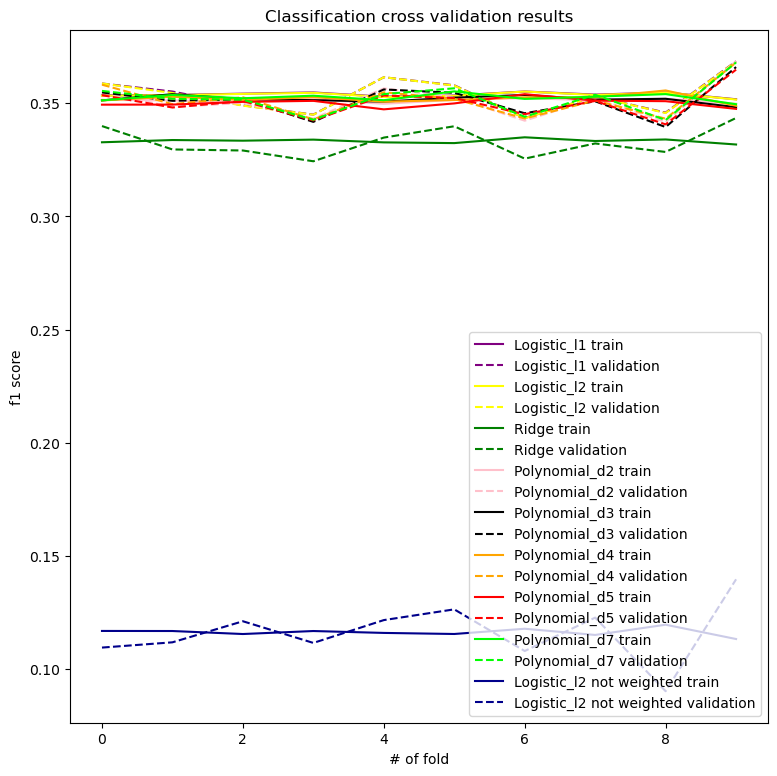

Model                     train scores                                                        validation scores
------------------------  ------------------------------------------------------------------  ------------------------------------------------------------------
Logistic_l1               [0.35347525 0.35364697 0.35423827 0.35477206 0.35290262 0.35341148  [0.35873183 0.35517536 0.34906157 0.34498348 0.36149243 0.35793486
                           0.35519622 0.35382448 0.35475578 0.35175879]                        0.34347976 0.35300298 0.34585943 0.36854783]
Logistic_l2               [0.35334106 0.35353985 0.35412444 0.35460582 0.35277108 0.35327965  [0.35873183 0.35455168 0.34893915 0.3449235  0.36149243 0.35781088
                           0.35516621 0.35365407 0.35471902 0.35164538]                        0.343361   0.35300298 0.34567901 0.36842105]
Ridge                     [0.33274876 0.33374376 0.33345611 0.33392205 0.33270578 0.33238502  [0.33991088 0.32957877 0.329117

In [64]:
folds=10
threshold = 0.4

models = {
    "Logistic_l1" : Classifier(LogisticRegression(penalty="l1", max_iter=100, class_weight='balanced', solver="saga"), threshold),
    "Logistic_l2" : Classifier(LogisticRegression(penalty="l2", max_iter=100, class_weight='balanced'), threshold),
    "Ridge" : RidgeClassifier(max_iter=100, class_weight='balanced'),
    "Polynomial_d2" : Polynomial(2, subestimator=Classifier(LogisticRegression(max_iter=100, class_weight='balanced'), threshold)),
    "Polynomial_d3" : Polynomial(3, subestimator=Classifier(LogisticRegression(max_iter=100, class_weight='balanced'), threshold)),
    "Polynomial_d4" : Polynomial(4, subestimator=Classifier(LogisticRegression(max_iter=100, class_weight='balanced'), threshold)),
    "Polynomial_d5" : Polynomial(5, subestimator=Classifier(LogisticRegression(max_iter=50, class_weight='balanced'), threshold)),
    "Polynomial_d7" : Polynomial(7, subestimator=Classifier(LogisticRegression(max_iter=50, class_weight='balanced'), threshold)),
    "Logistic_l2 not weighted" : Classifier(LogisticRegression(penalty="l2", max_iter=100), threshold)
}

table = []
colors = {"red", "yellow","black", "green", "gray", "orange", "purple", "pink", "blue", "lime", "darkblue"}
plt.rcParams["figure.figsize"] = (9,9)
for n in models:
    c = colors.pop()

    cv = cross_validate(models[n], x_train_c_piped, y_train_c,
                        cv=StratifiedKFold(folds, shuffle=True, random_state=RANDOM_STATE),
                        return_train_score=True, scoring="f1")
    table.append([n, cv["train_score"], cv["test_score"]])
    plt.plot(np.arange(folds), cv["train_score"], c=c, label=f'{n} train')
    plt.plot(np.arange(folds), cv["test_score"], c=c, linestyle="dashed", label=f'{n} validation')

plt.legend(loc='lower right')
plt.title("Classification cross validation results")
plt.xlabel("# of fold")
plt.ylabel("f1 score")
plt.show()

print(tabulate(table, headers=["Model", "train scores", "validation scores"]))

#### Section 3.4: evaluation of the models
Previously we performed validation of our models on training set and selected optimal parameters. Now we will compare productivity of our best data on test dataset and determine the optimal model for our final solution.
Based on our findings above, I include the following models for evaluation:
    1. Logistic Regression classifier model with L2 penalty as the most stable model
    2. Logistic Regression classifier with Ridge regularization
    3. Logistic Regression classifiers with 4-7 degrees polynomial features as it is great compromise between stability and productivity

For our final estimation it is best to use unweighted f1 and recall scores as those weakly reflect on lowered TPs being weighted. On the other hand, weighted precision will overreact on imbalance as FP tends to be much greater than TP due to class imbalance. It might seem that polynomial model with 7th degree features performs best on the set with no or limited overfitting. Probably we could increase complexity of the model, however, computing capabilities of my machine do not allow to calculate extra polinomial features and discarding more features will end up with deteriorating the model.

As we can observe on confusion matrix plot below, it seems that our model can catch over 50% of bad stream quality with just a little percentage of false positives which should be okay for further application.

MODEL            accuracy score    precision weighted score    recall_score    f1_score
-------------  ----------------  --------------------------  --------------  ----------
Logistic_l2            0.899153                    0.922704        0.500892    0.39024
Ridge                  0.893886                    0.922254        0.510768    0.382799
Polynomial_d4          0.884703                    0.920117        0.50771     0.362001
Polynomial_d5          0.883709                    0.921073        0.522238    0.366547
Polynomial_d7          0.900245                    0.923391        0.506372    0.395432


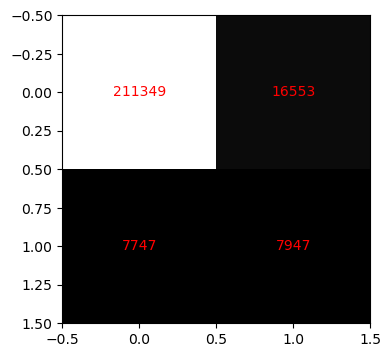

In [65]:
threshold = 0.45

models_final = {
    "Logistic_l2" : Classifier(LogisticRegression(penalty="l2", max_iter=100, class_weight='balanced'), threshold),
    "Ridge" : RidgeClassifier(max_iter=100, class_weight='balanced'),
    "Polynomial_d4" : Polynomial(4, subestimator=Classifier(LogisticRegression(max_iter=100, class_weight='balanced'), threshold)),
    "Polynomial_d5" : Polynomial(5, subestimator=Classifier(LogisticRegression(max_iter=100, class_weight='balanced'), threshold)),
    "Polynomial_d7" : Polynomial(7, subestimator=Classifier(LogisticRegression(max_iter=100, class_weight='balanced'), threshold-0.1))
}

metrics = {
    "accuracy score" : lambda x, y: accuracy_score(x, y),
    "precision weighted score" : lambda x, y: precision_score(x, y, average="weighted"),
    "recall_score" : lambda x, y: recall_score(x, y),
    "f1_score" : lambda x, y: f1_score(x, y)
}

x_test_c_piped, y_test_c = class_pipe(x_test_c.drop("stream_quality", axis=1), x_test_c["stream_quality"], with_pca=True)

table = []
for n in models_final:
    scores = evaluate_model(models_final[n], x_train_c_piped, y_train_c, x_test_c_piped, y_test_c, fit_model=True, metrics=metrics)[0]
    table.append([n] + [scores[t] for t in scores])

print(tabulate(table, headers=["MODEL"] + [t for t in metrics]))
_ = plot_confusion_matrix(y_test_c, models_final["Polynomial_d7"].predict(x_test_c_piped))